### 创建一个类别条件扩散模型

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 7, 0, 5, 2, 1, 2, 0])


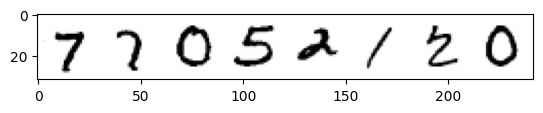

In [2]:
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# 输入 dataloader (这里 batch_size 设为8，你也可以视情况修改)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 抽样可视化图片
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [3]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()
    
    # embedding 层会把类别标签映射为 class_emb_size 形状的向量
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model 是一个非条件 UNet，因此并不包含额外的通道，无法拼接条件信息（类别 embedding）
    self.model = UNet2DModel(
        sample_size=28,           # 目标图片分辨率
        in_channels=1 + class_emb_size, # 额外的通道数 
        out_channels=1,           # 输出通道数 
        layers_per_block=2,       # UNet Block 内的 ResNet 层数
        block_out_channels=(32, 64, 64), 
        down_block_types=( 
            "DownBlock2D",        # 常规 ResNet 下采样 block
            "AttnDownBlock2D",    # 带有 2 维自注意力机制的 ResNet 下采样 block
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "AttnUpBlock2D",      # 带有 2 维自注意力机制的 ResNet 上采样 block
            "UpBlock2D",          # 常规 ResNet 上采样 block
          ),
    )

  # 前向计算函数接收额外的类别参数 
  def forward(self, x, t, class_labels):
    # x 的形状:
    bs, ch, w, h = x.shape
    
    # 映射类别条件信息与图片信息融合需要形状匹配
    class_cond = self.class_emb(class_labels) # 映射类别条件信息到目标形状
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x 形状为 (bs, 1, 28, 28)， class_cond 现在的形状为 (bs, 4, 28, 28)

    # 沿着维度为 1（从 0 开始）轴拼接 x 和 class_cond
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # 将 net_input 和 时间步信息一同送入模型预测图片输出
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [4]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

100%|██████████| 469/469 [00:39<00:00, 12.00it/s]


Finished epoch 0. Average of the last 100 loss values: 0.053839


100%|██████████| 469/469 [00:37<00:00, 12.39it/s]


Finished epoch 1. Average of the last 100 loss values: 0.046665


100%|██████████| 469/469 [00:38<00:00, 12.22it/s]


Finished epoch 2. Average of the last 100 loss values: 0.044522


100%|██████████| 469/469 [00:38<00:00, 12.24it/s]


Finished epoch 3. Average of the last 100 loss values: 0.042898


100%|██████████| 469/469 [00:38<00:00, 12.33it/s]


Finished epoch 4. Average of the last 100 loss values: 0.041539


100%|██████████| 469/469 [00:37<00:00, 12.49it/s]


Finished epoch 5. Average of the last 100 loss values: 0.040276


100%|██████████| 469/469 [00:37<00:00, 12.35it/s]


Finished epoch 6. Average of the last 100 loss values: 0.039764


100%|██████████| 469/469 [00:38<00:00, 12.27it/s]


Finished epoch 7. Average of the last 100 loss values: 0.039508


100%|██████████| 469/469 [00:38<00:00, 12.23it/s]


Finished epoch 8. Average of the last 100 loss values: 0.038651


100%|██████████| 469/469 [00:38<00:00, 12.19it/s]

Finished epoch 9. Average of the last 100 loss values: 0.039698


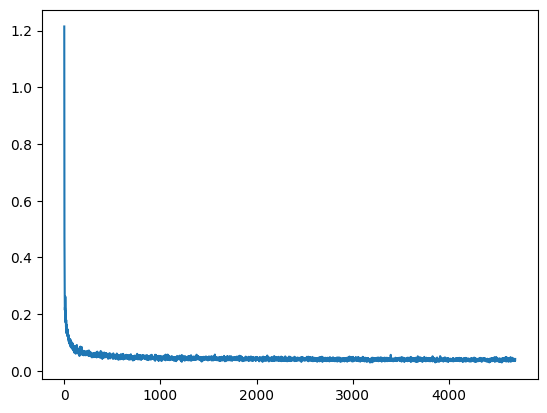

In [5]:
# 重定义 dataloader，设置 batch_size （可以比先前 demo 中大得多）
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 思考一下设置多少 epoch 比较好？
n_epochs = 10

# 网络架构 
net = ClassConditionedUnet().to(device)

# 损失函数
loss_fn = nn.MSELoss()

# 优化器
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# 记录 loss 以便后续分析 loss 曲线
losses = []

# 训练循环
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # 训练数据准备
        x = x.to(device) * 2 - 1 # 转移数据至 GPU 并归一化 (-1, 1)
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # 获取模型预测输出
        pred = net(noisy_x, timesteps, y) # 注意传入类别标签 y

        # 计算 loss
        loss = loss_fn(pred, noise) # 度量预测和噪声的相似程度

        # 反向传播，更新参数
        opt.zero_grad()
        loss.backward()
        opt.step()

        # 记录 loss
        losses.append(loss.item())

    # 每 100 个样本打印一次平均 loss，不时查看一下训练进展情况
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# 可视化 loss 曲线
plt.plot(losses)

0it [00:00, ?it/s]

6it [00:00, 56.87it/s]

0
1
2
3
4
5
6
7
8
9
10
11


18it [00:00, 57.75it/s]

12
13
14
15
16
17
18
19
20
21
22
23


30it [00:00, 58.77it/s]

24
25
26
27
28
29
30
31
32
33
34
35


42it [00:00, 58.05it/s]

36
37
38
39
40
41
42
43
44
45
46
47


55it [00:00, 58.67it/s]

48
49
50
51
52
53
54
55
56
57
58


68it [00:01, 56.31it/s]

59
60
61
62
63
64
65
66
67
68
69
70
71


80it [00:01, 57.67it/s]

72
73
74
75
76
77
78
79
80
81
82
83


93it [00:01, 59.03it/s]

84
85
86
87
88
89
90
91
92
93
94
95
96


106it [00:01, 59.75it/s]

97
98
99
100
101
102
103
104
105
106
107
108
109


118it [00:02, 58.43it/s]

110
111
112
113
114
115
116
117
118
119
120
121


130it [00:02, 56.64it/s]

122
123
124
125
126
127
128
129
130
131
132
133


143it [00:02, 57.19it/s]

134
135
136
137
138
139
140
141
142
143
144
145


156it [00:02, 58.73it/s]

146
147
148
149
150
151
152
153
154
155
156
157
158


169it [00:02, 59.87it/s]

159
160
161
162
163
164
165
166
167
168
169
170
171


182it [00:03, 60.38it/s]

172
173
174
175
176
177
178
179
180
181
182
183
184


196it [00:03, 60.95it/s]

185
186
187
188
189
190
191
192
193
194
195
196
197


203it [00:03, 60.75it/s]

198
199
200
201
202
203
204
205
206
207
208
209


216it [00:03, 57.66it/s]

210
211
212
213
214
215
216
217
218
219
220
221


228it [00:03, 58.42it/s]

222
223
224
225
226
227
228
229
230
231
232
233


241it [00:04, 59.39it/s]

234
235
236
237
238
239
240
241
242
243
244
245
246


255it [00:04, 60.40it/s]

247
248
249
250
251
252
253
254
255
256
257
258
259


268it [00:04, 59.69it/s]

260
261
262
263
264
265
266
267
268
269
270
271


281it [00:04, 60.58it/s]

272
273
274
275
276
277
278
279
280
281
282
283
284


295it [00:05, 59.97it/s]

285
286
287
288
289
290
291
292
293
294
295
296


307it [00:05, 58.44it/s]

297
298
299
300
301
302
303
304
305
306
307
308


320it [00:05, 59.36it/s]

309
310
311
312
313
314
315
316
317
318
319
320
321


333it [00:05, 59.64it/s]

322
323
324
325
326
327
328
329
330
331
332
333


345it [00:05, 58.61it/s]

334
335
336
337
338
339
340
341
342
343
344
345


358it [00:06, 59.68it/s]

346
347
348
349
350
351
352
353
354
355
356
357
358


371it [00:06, 60.41it/s]

359
360
361
362
363
364
365
366
367
368
369
370
371


378it [00:06, 54.66it/s]

372
373
374
375
376
377
378
379
380
381
382
383


391it [00:06, 57.75it/s]

384
385
386
387
388
389
390
391
392
393
394
395
396


405it [00:06, 60.06it/s]

397
398
399
400
401
402
403
404
405
406
407
408
409


419it [00:07, 58.53it/s]

410
411
412
413
414
415
416
417
418
419
420


432it [00:07, 58.93it/s]

421
422
423
424
425
426
427
428
429
430
431
432
433


444it [00:07, 57.86it/s]

434
435
436
437
438
439
440
441
442
443
444
445


456it [00:07, 57.52it/s]

446
447
448
449
450
451
452
453
454
455
456
457


468it [00:08, 57.14it/s]

458
459
460
461
462
463
464
465
466
467
468
469


480it [00:08, 56.68it/s]

470
471
472
473
474
475
476
477
478
479
480
481


493it [00:08, 58.94it/s]

482
483
484
485
486
487
488
489
490
491
492
493
494


507it [00:08, 60.63it/s]

495
496
497
498
499
500
501
502
503
504
505
506
507


514it [00:08, 60.82it/s]

508
509
510
511
512
513
514
515
516
517
518
519
520


528it [00:08, 61.43it/s]

521
522
523
524
525
526
527
528
529
530
531
532
533


542it [00:09, 61.62it/s]

534
535
536
537
538
539
540
541
542
543
544
545
546


556it [00:09, 61.32it/s]

547
548
549
550
551
552
553
554
555
556
557
558
559


570it [00:09, 61.66it/s]

560
561
562
563
564
565
566
567
568
569
570
571
572


584it [00:09, 60.70it/s]

573
574
575
576
577
578
579
580
581
582
583
584


591it [00:10, 60.40it/s]

585
586
587
588
589
590
591
592
593
594
595
596
597


605it [00:10, 59.76it/s]

598
599
600
601
602
603
604
605
606
607


611it [00:10, 46.46it/s]

608
609
610
611
612
613


617it [00:10, 38.83it/s]

614
615
616
617
618
619


628it [00:10, 39.86it/s]

620
621
622
623
624
625
626
627
628
629
630
631


641it [00:11, 48.92it/s]

632
633
634
635
636
637
638
639
640
641
642
643
644


655it [00:11, 54.63it/s]

645
646
647
648
649
650
651
652
653
654
655
656
657


668it [00:11, 57.29it/s]

658
659
660
661
662
663
664
665
666
667
668
669
670


682it [00:11, 59.62it/s]

671
672
673
674
675
676
677
678
679
680
681
682
683


696it [00:12, 60.32it/s]

684
685
686
687
688
689
690
691
692
693
694
695
696


703it [00:12, 60.76it/s]

697
698
699
700
701
702
703
704
705
706
707
708
709


717it [00:12, 61.39it/s]

710
711
712
713
714
715
716
717
718
719
720
721


730it [00:12, 59.12it/s]

722
723
724
725
726
727
728
729
730
731
732
733


743it [00:12, 59.81it/s]

734
735
736
737
738
739
740
741
742
743
744
745
746


756it [00:13, 60.10it/s]

747
748
749
750
751
752
753
754
755
756
757


769it [00:13, 57.12it/s]

758
759
760
761
762
763
764
765
766
767
768
769


781it [00:13, 58.04it/s]

770
771
772
773
774
775
776
777
778
779
780
781


793it [00:13, 57.81it/s]

782
783
784
785
786
787
788
789
790
791
792
793


806it [00:13, 58.55it/s]

794
795
796
797
798
799
800
801
802
803
804
805


812it [00:14, 58.69it/s]

806
807
808
809
810
811
812
813
814
815
816
817
818


825it [00:14, 56.11it/s]

819
820
821
822
823
824
825
826
827
828
829


838it [00:14, 57.26it/s]

830
831
832
833
834
835
836
837
838
839
840
841
842


850it [00:14, 58.14it/s]

843
844
845
846
847
848
849
850
851
852
853


856it [00:14, 50.71it/s]

854
855
856
857
858
859
860
861


867it [00:15, 44.36it/s]

862
863
864
865
866
867
868
869
870
871
872


879it [00:15, 51.10it/s]

873
874
875
876
877
878
879
880
881
882
883
884
885


893it [00:15, 56.10it/s]

886
887
888
889
890
891
892
893
894
895
896
897
898


906it [00:15, 57.63it/s]

899
900
901
902
903
904
905
906
907
908
909
910


918it [00:16, 47.84it/s]

911
912
913
914
915
916
917
918


931it [00:16, 53.73it/s]

919
920
921
922
923
924
925
926
927
928
929
930
931


938it [00:16, 55.81it/s]

932
933
934
935
936
937
938
939
940
941
942
943
944


952it [00:16, 58.45it/s]

945
946
947
948
949
950
951
952
953
954
955
956
957


966it [00:16, 60.43it/s]

958
959
960
961
962
963
964
965
966
967
968
969
970


980it [00:17, 59.97it/s]

971
972
973
974
975
976
977
978
979
980
981
982
983


994it [00:17, 60.84it/s]

984
985
986
987
988
989
990
991
992
993
994
995
996


1000it [00:17, 57.26it/s]

997
998
999


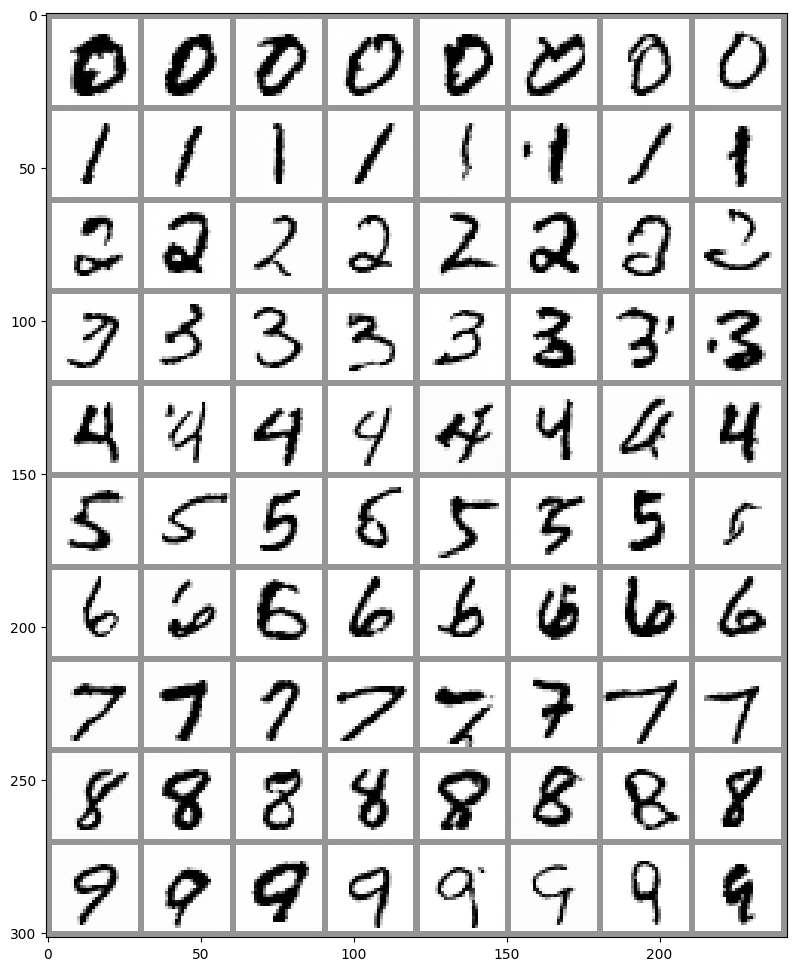

In [8]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# 采样循环
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    print(i)

    # 计算模型输出
    with torch.no_grad():
        residual = net(x, t, y)  # 再次提醒传入标签 y

    # 迭代去噪图片
    x = noise_scheduler.step(residual, t, x).prev_sample

# 可视化最终图片
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')